In [57]:
import numpy as np
import pandas as pd

### more dataset cleaning

In [187]:
clean = pd.read_csv("/Users/anab/Documents/MS_UCDavis/STA208/project/STA_208/data/clean.csv")

In [188]:
from Functions import Cleaning_Functions
fun = Cleaning_Functions()

## Ridge regre y = market orientation

In [270]:
market_data = fun.delete_id_columns(clean) #1
market_data, pred_market = fun.drop_response_rows_with_NAs(market_data, "Market_Orientation", "PPI_Likelihood") #2
market_data = fun.replace_NAN_with_na(market_data) #3
market_data = fun.entry_to_lowercase(market_data) #4
market_data = fun.remove_underscores_spaces(market_data) #5
market_data = fun.convert_to_categorical(market_data) #6
market_data = fun.impute_data(market_data)

In [202]:
market_data.YEAR = market_data.YEAR.astype('category')

In [203]:
def standarize_data(df):
    
    """
    Input: a dataset
    action: returns numeric column values scaled by mean and standard deviation
    """
    numeric_data = df.select_dtypes(include=['float64', 'int64'])
    for i in numeric_data.columns:
        df[i] = (df[i] - df[i].mean())/df[i].std()
    return df

In [204]:
market_data = standarize_data(market_data)

## Ridge Regression 

In [205]:
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

### 1. create dummy

In [206]:
def get_dummyXs_y(df, y_var):
    
    y = df[y_var]
    X  = df.drop(y_var, axis = 1)
    X_cat = X.select_dtypes(include = ["category", "O"])
    X_num = X.select_dtypes(include=['float64', 'int64'])
    
    X_cat_dummy = pd.get_dummies(X_cat)
    newX = pd.concat([X_num, X_cat_dummy], axis = 1)
    
    return newX, y

In [207]:
X_market = get_dummyXs_y(market_data, "Market_Orientation")[0]
X_market = X_market.drop("Livestock_Orientation", axis=1)
y_market = get_dummyXs_y(market_data, "Market_Orientation")[1]

In [208]:
X_train, X_test, y_train, y_test = train_test_split(X_market,y_market, test_size = 0.3, random_state = 2021)


In [209]:
alpha_set = np.arange(100,800,10)
ridge_cv=RidgeCV(alphas=alpha_set, store_cv_values = True, fit_intercept = False)
model_cv=ridge_cv.fit(X_train,y_train)
model_cv.alpha_

450

In [210]:
cv_per_alpha = np.mean(model_cv.cv_values_, axis = 0)

In [211]:
cv_df = pd.DataFrame({'alpha': alpha_set, 'MSPE': cv_per_alpha})

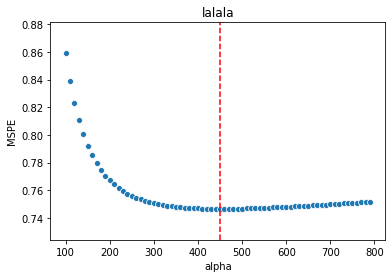

In [212]:
sns.scatterplot(data = cv_df, x = "alpha", y = "MSPE").set_title('lalala')
plt.axvline(x=450, c="red", linestyle = "dashed")


In [139]:
#refit model with alpha =3 and get score
rir = Ridge(alpha = model_cv.alpha_)
rir.fit(X_train,y_train)
y_pred_ridge = rir.predict(X_test)
MSE_market = mean_squared_error(y_test,y_pred_ridge)
MSE_market

0.7100798040090596

In [140]:
rir.coef_

array([-1.11313252e-02, -1.39127931e-02, -1.19075036e-02, -1.25263210e-02,
        6.30272937e-03, -1.81190333e-01, -2.53103539e-02,  1.41439568e-02,
       -4.02228764e-03, -1.37021744e-03, -3.71355991e-02, -4.22787825e-02,
       -4.47039830e-02, -9.61575090e-03,  8.02705490e-03, -3.51784929e-03,
        1.45344373e-02,  1.34435055e-02,  1.44716966e-02,  1.36387549e-02,
       -5.79899566e-02,  8.06205250e-03, -1.01424164e-02, -1.47878515e-02,
       -3.24536179e-03, -3.94803193e-03,  3.33412664e-02, -7.12080626e-02,
        7.12080626e-02, -8.80308216e-03,  6.78100744e-03,  8.20693247e-04,
       -2.51942207e-02, -3.31898767e-02,  5.53119221e-03, -1.99501954e-02,
        5.77953924e-02, -4.36024083e-02,  4.45105403e-04,  3.46451484e-03,
       -3.41438520e-03, -4.06890904e-02,  0.00000000e+00, -1.59977732e-03,
        7.13086380e-03,  1.33534475e-03,  2.55866148e-03,  2.05843054e-02,
        7.96644196e-04, -8.19111882e-03, -1.37411256e-03, -2.64727051e-03,
        1.39575231e-03,  

In [141]:
betas = rir.coef_
max5_index = [list(abs(betas)).index(x) for x in np.sort(abs(betas))[::-1][:20]]
min5_index = [list(abs(betas)).index(x) for x in np.sort(abs(betas))[:5]]

In [142]:
betas[max5_index]

array([-0.42165681, -0.24504512, -0.22207401,  0.19818947, -0.18119033,
        0.15152416, -0.11773792,  0.10894719,  0.09468214, -0.0921594 ,
        0.08678049, -0.08138686,  0.07997271,  0.07845798,  0.07828577,
        0.07783293,  0.07331506,  0.07301027,  0.07120806, -0.07120806])

In [143]:
betas[min5_index]

array([0.        , 0.        , 0.        , 0.        , 0.00012335])

In [144]:
X_train.columns[max5_index]

Index(['Country_tanzania', 'Country_kenya', 'YEAR_2017', 'Country_burkinafaso',
       'LivestockHoldings', 'Country_mali', 'Country_laopdr',
       'crop_name_1_greengram', 'YEAR_2016', 'HouseholdType_womansingle',
       'YEAR_2015', 'crop_name_1_rice', 'Country_cambodia', 'Country_drc',
       'crop_intercrop_1_na', 'crop_harvest_1_na', 'HouseholdType_couple',
       'Country_zambia', 'Gender_FemaleControl', 'Gender_MaleControl'],
      dtype='object')

In [145]:
feature_imp_mo  = pd.DataFrame([X_train.columns[max5_index], betas[max5_index]]).T
feature_imp_mo

,0,1
0,Country_tanzania,-0.421657
1,Country_kenya,-0.245045
2,YEAR_2017,-0.222074
3,Country_burkinafaso,0.198189
4,LivestockHoldings,-0.18119
5,Country_mali,0.151524
6,Country_laopdr,-0.117738
7,crop_name_1_greengram,0.108947
8,YEAR_2016,0.0946821
9,HouseholdType_womansingle,-0.0921594


### predict y for market orientation y = Na

In [271]:
pred_market = pred_market.drop("continent","Livestock_Orientation"], axis = 1)

In [272]:
pred_market

,crop_count,crop_name_1,crop_harvest_1,crop_intercrop_1,YEAR,Country,HHsizemembers,HHsizeMAE,HouseholdType,Head_EducationLevel,...,livestock_prodsales_USD_PPP_pHH_Yr,value_livestock_production_USD_PPP_pHH_Yr,value_livestock_prod_consumed_USD_PPP_pHH_Yr,Market_Orientation,Livestock_Orientation,Food_Availability_kCal_MAE_day,Food_Self_Sufficiency_kCal_MAE_day,NrofMonthsWildFoodCons,Gender_MaleControl,Gender_FemaleControl
3,NaN,cowpea,NaN,NaN,2015,Tanzania,11,9.33,together,primary,...,0.0,0.0,0.0,NaN,NaN,257.234727,257.234727,0,NaN,NaN
15,NaN,groundnut,NaN,NaN,2015,Tanzania,4,2.86,together,illiterate,...,0.0,0.0,0.0,NaN,NaN,296.878322,296.878322,12,1.0,0.0
16,NaN,sesame,NaN,NaN,2015,Tanzania,0,NaN,single,primary,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0,NaN,NaN
20,1.0,sorghum,normal_harvest,monoculture,2015,Tanzania,5,3.72,together,illiterate,...,0.0,0.0,0.0,NaN,NaN,280.777729,280.777729,1,1.0,0.0
29,4.0,maize,normal_harvest,monoculture,2015,Tanzania,4,2.61,single,illiterate,...,0.0,0.0,0.0,NaN,NaN,903.459109,903.459109,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11946,1.0,maize,normal_harvest,monoculture,2018,Ghana,7,4.96,couple,No_school,...,0.0,0.0,0.0,NaN,NaN,0.000000,0.000000,6,NaN,NaN
11953,3.0,maize,bad_harvest,monoculture,2018,Ghana,11,8.16,woman_single,No_school,...,0.0,0.0,0.0,NaN,NaN,61.274510,61.274510,0,1.0,0.0
11956,1.0,maize,bad_harvest,monoculture,2018,Ghana,7,4.93,couple,No_school,...,0.0,0.0,0.0,NaN,NaN,1052.821696,1052.821696,9,1.0,0.0
11958,5.0,maize,good_harvest,monoculture,2018,Ghana,7,4.78,couple,No_school,...,0.0,0.0,0.0,NaN,NaN,355.648536,355.648536,5,1.0,0.0


In [273]:
pred_market = fun.replace_NAN_with_na(pred_market) #3
pred_market = fun.entry_to_lowercase(pred_market) #4
pred_market = fun.remove_underscores_spaces(pred_market) #5
pred_market = fun.convert_to_categorical(pred_market) #6
pred_market = fun.impute_data(pred_market)
pred_market = standarize_data(pred_market)

pred_market.YEAR = pred_market.YEAR.astype('category')

pred_market = pred_market.reset_index(drop = True)


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


In [274]:
pred_market


,crop_count,crop_name_1,crop_harvest_1,crop_intercrop_1,YEAR,Country,HHsizemembers,HHsizeMAE,HouseholdType,Head_EducationLevel,...,livestock_prodsales_USD_PPP_pHH_Yr,value_livestock_production_USD_PPP_pHH_Yr,value_livestock_prod_consumed_USD_PPP_pHH_Yr,Market_Orientation,Livestock_Orientation,Food_Availability_kCal_MAE_day,Food_Self_Sufficiency_kCal_MAE_day,NrofMonthsWildFoodCons,Gender_MaleControl,Gender_FemaleControl
0,-0.313234,cowpea,na,na,-2.503957,tanzania,0.395722,0.554376,together,primary,...,NaN,NaN,NaN,NaN,NaN,-0.040167,-0.040152,-0.550898,0.100887,-0.100887
1,-0.313234,groundnut,na,na,-2.503957,tanzania,-0.548666,-0.599658,together,illiterate,...,NaN,NaN,NaN,NaN,NaN,-0.040124,-0.040109,3.639602,0.100887,-0.100887
2,-0.313234,sesame,na,na,-2.503957,tanzania,-1.088317,-0.234897,single,primary,...,NaN,NaN,NaN,NaN,NaN,-0.039657,-0.039671,-0.550898,0.100887,-0.100887
3,-1.000679,sorghum,normalharvest,monoculture,-2.503957,tanzania,-0.413754,-0.446262,together,illiterate,...,NaN,NaN,NaN,NaN,NaN,-0.040141,-0.040126,-0.201689,0.100887,-0.100887
4,1.061655,maize,normalharvest,monoculture,-2.503957,tanzania,-0.548666,-0.644250,single,illiterate,...,NaN,NaN,NaN,NaN,NaN,-0.039454,-0.039439,-0.550898,0.100887,-0.100887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2464,-1.000679,maize,normalharvest,monoculture,0.745309,ghana,-0.143929,-0.225087,couple,noschool,...,NaN,NaN,NaN,NaN,NaN,-0.040451,-0.040436,1.544352,0.100887,-0.100887
2465,0.374210,maize,badharvest,monoculture,0.745309,ghana,0.395722,0.345687,womansingle,noschool,...,NaN,NaN,NaN,NaN,NaN,-0.040384,-0.040369,-0.550898,0.100887,-0.100887
2466,-1.000679,maize,badharvest,monoculture,0.745309,ghana,-0.143929,-0.230438,couple,noschool,...,NaN,NaN,NaN,NaN,NaN,-0.039290,-0.039274,2.591977,0.100887,-0.100887
2467,1.749100,maize,goodharvest,monoculture,0.745309,ghana,-0.143929,-0.257193,couple,noschool,...,NaN,NaN,NaN,NaN,NaN,-0.040059,-0.040044,1.195144,0.100887,-0.100887


In [275]:
iss = []
sumNA = []
for i in X_pred_vals.columns:
    iss.append(i)
    a = X_pred_vals[i].isna().sum()
    sumNA.append(a)

In [276]:
a =pd.DataFrame({'label': iss, 'numNA': sumNA})
a[13:24].label
pred_market = pred_market.drop(a[13:24].label,axis = 1)

In [277]:

X_pred_vals = get_dummyXs_y(pred_market, "Market_Orientation")[0]
X_pred_vals = X_pred_vals.drop(["Livestock_Orientation"], axis=1)
#y_market_pre = get_dummyXs_y(pred_market, "Market_Orientation")[1]



In [278]:
#refit model with alpha =3 and get score
rir = Ridge(alpha = model_cv.alpha_)
rir.fit(X_train,y_train)
y_nas_pred = rir.predict(X_pred_vals)
y_nas_pred

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 157 is different from 117)

## Ridge regression with y=PPI_Likelihood

In [138]:
ppi_data, pred_ppi = fun.drop_response_rows_with_NAs(clean,"PPI_Likelihood" ,"Market_Orientation") #2


In [127]:
clean  = fun.delete_id_columns(clean) 
clean = fun.replace_NAN_with_na(clean)
clean = fun.entry_to_lowercase(clean)
clean = fun.remove_underscores_spaces(clean)
clean = fun.impute_data(clean)
clean = fun.convert_to_categorical(clean)
clean

,crop_count,crop_name_1,crop_harvest_1,crop_intercrop_1,YEAR,Country,HHsizemembers,HHsizeMAE,HouseholdType,Head_EducationLevel,...,value_livestock_production_USD_PPP_pHH_Yr,value_livestock_prod_consumed_USD_PPP_pHH_Yr,Market_Orientation,Livestock_Orientation,Food_Availability_kCal_MAE_day,Food_Self_Sufficiency_kCal_MAE_day,NrofMonthsWildFoodCons,Gender_MaleControl,Gender_FemaleControl,continent
0,2.0,groundnut,na,na,2015,tanzania,4,3.32,single,primary,...,38.500640,0.000000,1.000000,0.049505,3650.565755,0.000000,0,0.000000,1.000000,africa
1,2.0,millet,na,na,2015,tanzania,10,5.85,together,primary,...,0.000000,0.000000,1.000000,0.000000,3632.448997,0.000000,4,0.499999,0.500001,africa
2,2.0,groundnut,na,na,2015,tanzania,5,4.32,together,illiterate,...,128.335467,0.000000,1.000000,0.129870,5314.779021,1750.000000,1,1.000000,0.000000,africa
3,2.0,cowpea,na,na,2015,tanzania,11,9.33,together,primary,...,0.000000,0.000000,1.000000,0.310907,257.234727,257.234727,0,0.999984,0.000016,africa
4,2.0,sesame,na,na,2015,tanzania,6,5.41,together,secondary,...,233.994961,23.102694,0.931377,0.695041,925.310354,22.070240,0,1.000000,0.000000,africa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11957,3.0,maize,goodharvest,monoculture,2018,ghana,8,5.43,couple,primary,...,655.292919,0.000000,1.000000,0.779661,1615.869392,339.743848,7,0.629176,0.370824,africa
11958,5.0,maize,goodharvest,monoculture,2018,ghana,7,4.78,couple,noschool,...,0.000000,0.000000,1.000000,0.310907,355.648536,355.648536,5,1.000000,0.000000,africa
11959,2.0,maize,badharvest,intercrop,2018,ghana,4,3.20,mansingle,noschool,...,49.859244,0.000000,0.456522,0.456522,379.050204,276.284247,0,0.000000,1.000000,africa
11960,2.0,maize,badharvest,intercrop,2018,ghana,4,3.10,couple,noschool,...,0.000000,0.000000,1.000000,0.310907,693.504198,693.504198,0,1.000000,0.000000,africa


In [139]:
# ppi_data = fun.delete_id_columns(clean) #1
# ppi_data, pred_market = fun.drop_response_rows_with_NAs(ppi_data,"PPI_Likelihood" ,"Market_Orientation") #2
# ppi_data = fun.replace_NAN_with_na(ppi_data) #3
# ppi_data = fun.entry_to_lowercase(ppi_data) #4
# ppi_data = fun.remove_underscores_spaces(ppi_data) #5
# ppi_data = fun.convert_to_categorical(ppi_data) #6
# ppi_data = fun.impute_data(ppi_data)#7

In [140]:
ppi_data.YEAR = ppi_data.YEAR.astype('category')
ppi_data = standarize_data(ppi_data)

In [141]:
X_ppi = get_dummyXs_y(ppi_data, "PPI_Likelihood")[0]
y_ppi = get_dummyXs_y(ppi_data, "PPI_Likelihood")[1]

In [142]:
X_train_ppi, X_test_ppi, y_train_ppi, y_test_ppi = train_test_split(X_ppi ,y_ppi, test_size = 0.3, random_state = 2021)


In [143]:
alpha_set = np.arange(10,80,1)
ridge_cv_ppi=RidgeCV(alphas=alpha_set, store_cv_values = True, fit_intercept = False)
model_ppi_cv=ridge_cv_ppi.fit(X_train_ppi,y_train_ppi)
model_ppi_cv.alpha_

48

In [144]:
ppi_cv_per_alpha = np.mean(model_ppi_cv.cv_values_, axis = 0)
ppi_cv_df = pd.DataFrame({'alpha': alpha_set, 'MSPE': ppi_cv_per_alpha})

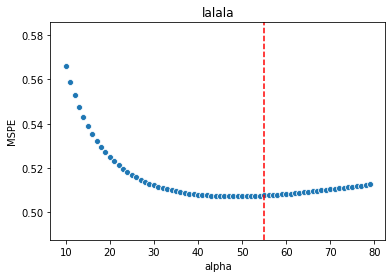

In [145]:
sns.scatterplot(data = ppi_cv_df, x = "alpha", y = "MSPE").set_title('lalala')
plt.axvline(x=55, c="red", linestyle = "dashed")

In [146]:
#refit model with alpha =3 and get score
ridge_ppi = Ridge(alpha = model_ppi_cv.alpha_)
ridge_ppi.fit(X_train_ppi,y_train_ppi)
y_pred_ridge_ppi = ridge_ppi.predict(X_test_ppi)
MSE_ppi = np.mean((y_pred_ridge_ppi-np.array(y_test_ppi))**2)
MSE_ppi

0.5452949897654191

In [148]:
#top 20 coeff/variable that are most important by abs value
betas_ppi = ridge_ppi.coef_
max5_index_ppi = [list(abs(betas_ppi)).index(x) for x in np.sort(abs(betas_ppi))[::-1][:20]]
min5_index_ppi = [list(abs(betas_ppi)).index(x) for x in np.sort(abs(betas_ppi))[:5]]

In [154]:
betas_ppi[max5_index_ppi]

array([ 1.44732316,  1.43027839, -1.00024503, -0.82115931,  0.80273365,
       -0.53769012, -0.40322078, -0.39439136, -0.39065783, -0.35620848,
        0.26009835,  0.25259397, -0.24119817,  0.24096484, -0.23133748,
        0.20271981, -0.19417709, -0.18888857, -0.18059029, -0.17389786])

In [150]:
betas_ppi[min5_index_ppi]

array([0., 0., 0., 0., 0.])

In [156]:
X_train.columns[max5_index_ppi]

Index(['Country_mali', 'Country_zambia', 'Country_guatemala', 'Country_ghana',
       'Country_malawi', 'Country_peru', 'Country_uganda',
       'crop_name_1_irishpotato', 'Country_india', 'Country_cambodia',
       'HHsizemembers', 'Head_EducationLevel_noschool', 'Country_drc',
       'Country_elsalvador', 'Head_EducationLevel_secondary',
       'Country_tanzania', 'Country_ethiopia', 'HHsizeMAE',
       'HouseholdType_together', 'Country_honduras'],
      dtype='object')

In [157]:
feature_imp_ppi  = pd.DataFrame([X_train.columns[max5_index_ppi], betas[max5_index_ppi]]).T
feature_imp_ppi

,0,1
0,Country_mali,0.150641
1,Country_zambia,0.11049
2,Country_guatemala,0.021191
3,Country_ghana,0.0247498
4,Country_malawi,0.0342796
5,Country_peru,0.0474055
6,Country_uganda,0.0377396
7,crop_name_1_irishpotato,0.00787746
8,Country_india,0.0374728
9,Country_cambodia,0.0260964


In [158]:
pd.concat([feature_imp_ppi, feature_imp_mo],axis = 1)

,0,1,0,1
0,Country_mali,0.150641,Country_tanzania,-0.431144
1,Country_zambia,0.11049,Livestock_Orientation,-0.251226
2,Country_guatemala,0.021191,YEAR_2017,-0.225168
3,Country_ghana,0.0247498,Country_burkinafaso,0.202165
4,Country_malawi,0.0342796,Country_kenya,-0.170534
5,Country_peru,0.0474055,Country_mali,0.150641
6,Country_uganda,0.0377396,LivestockHoldings,-0.147021
7,crop_name_1_irishpotato,0.00787746,value_crop_consumed_USD_PPP_pHH_Yr,-0.146729
8,Country_india,0.0374728,Country_zambia,0.11049
9,Country_cambodia,0.0260964,crop_name_1_greengram,0.109344


[primary, illiterate, secondary, literate, noschool, ..., postsecondary, informal, none, religiousschool, islamicschool]
Length: 27
Categories (27, object): [primary, illiterate, secondary, literate, ..., informal, none, religiousschool, islamicschool]

412

## drop countries 

In [153]:
# clean = pd.read_csv("/Users/anab/Documents/MS_UCDavis/STA208/project/STA_208/data/clean.csv")
# from Functions import Cleaning_Functions
# fun = Cleaning_Functions()

# clean  = fun.delete_id_columns(clean) 
# clean = fun.replace_NAN_with_na(clean)
# clean = fun.entry_to_lowercase(clean)
# clean = fun.remove_underscores_spaces(clean)
# clean = fun.impute_data(clean)
# clean = fun.convert_to_categorical(clean)
# clean

,crop_count,crop_name_1,crop_harvest_1,crop_intercrop_1,YEAR,Country,HHsizemembers,HHsizeMAE,HouseholdType,Head_EducationLevel,...,value_livestock_production_USD_PPP_pHH_Yr,value_livestock_prod_consumed_USD_PPP_pHH_Yr,Market_Orientation,Livestock_Orientation,Food_Availability_kCal_MAE_day,Food_Self_Sufficiency_kCal_MAE_day,NrofMonthsWildFoodCons,Gender_MaleControl,Gender_FemaleControl,continent
0,2.0,groundnut,na,na,2015,tanzania,4,3.32,single,primary,...,38.500640,0.000000,1.000000,0.049505,3650.565755,0.000000,0,0.000000,1.000000,africa
1,2.0,millet,na,na,2015,tanzania,10,5.85,together,primary,...,0.000000,0.000000,1.000000,0.000000,3632.448997,0.000000,4,0.499999,0.500001,africa
2,2.0,groundnut,na,na,2015,tanzania,5,4.32,together,illiterate,...,128.335467,0.000000,1.000000,0.129870,5314.779021,1750.000000,1,1.000000,0.000000,africa
3,2.0,cowpea,na,na,2015,tanzania,11,9.33,together,primary,...,0.000000,0.000000,1.000000,0.310907,257.234727,257.234727,0,0.999984,0.000016,africa
4,2.0,sesame,na,na,2015,tanzania,6,5.41,together,secondary,...,233.994961,23.102694,0.931377,0.695041,925.310354,22.070240,0,1.000000,0.000000,africa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11957,3.0,maize,goodharvest,monoculture,2018,ghana,8,5.43,couple,primary,...,655.292919,0.000000,1.000000,0.779661,1615.869392,339.743848,7,0.629176,0.370824,africa
11958,5.0,maize,goodharvest,monoculture,2018,ghana,7,4.78,couple,noschool,...,0.000000,0.000000,1.000000,0.310907,355.648536,355.648536,5,1.000000,0.000000,africa
11959,2.0,maize,badharvest,intercrop,2018,ghana,4,3.20,mansingle,noschool,...,49.859244,0.000000,0.456522,0.456522,379.050204,276.284247,0,0.000000,1.000000,africa
11960,2.0,maize,badharvest,intercrop,2018,ghana,4,3.10,couple,noschool,...,0.000000,0.000000,1.000000,0.310907,693.504198,693.504198,0,1.000000,0.000000,africa


In [154]:
# test1  = clean.drop("continent", axis =1)
# test1.head()

,crop_count,crop_name_1,crop_harvest_1,crop_intercrop_1,YEAR,Country,HHsizemembers,HHsizeMAE,HouseholdType,Head_EducationLevel,...,livestock_prodsales_USD_PPP_pHH_Yr,value_livestock_production_USD_PPP_pHH_Yr,value_livestock_prod_consumed_USD_PPP_pHH_Yr,Market_Orientation,Livestock_Orientation,Food_Availability_kCal_MAE_day,Food_Self_Sufficiency_kCal_MAE_day,NrofMonthsWildFoodCons,Gender_MaleControl,Gender_FemaleControl
0,2.0,groundnut,na,na,2015,tanzania,4,3.32,single,primary,...,38.500640,38.500640,0.000000,1.000000,0.049505,3650.565755,0.000000,0,0.000000,1.000000
1,2.0,millet,na,na,2015,tanzania,10,5.85,together,primary,...,0.000000,0.000000,0.000000,1.000000,0.000000,3632.448997,0.000000,4,0.499999,0.500001
2,2.0,groundnut,na,na,2015,tanzania,5,4.32,together,illiterate,...,128.335467,128.335467,0.000000,1.000000,0.129870,5314.779021,1750.000000,1,1.000000,0.000000
3,2.0,cowpea,na,na,2015,tanzania,11,9.33,together,primary,...,0.000000,0.000000,0.000000,1.000000,0.310907,257.234727,257.234727,0,0.999984,0.000016
4,2.0,sesame,na,na,2015,tanzania,6,5.41,together,secondary,...,210.892267,233.994961,23.102694,0.931377,0.695041,925.310354,22.070240,0,1.000000,0.000000


In [155]:
# p1, predm = fun.drop_response_rows_with_NAs(test1,"PPI_Likelihood" ,"Market_Orientation") #2



In [156]:
# p1.YEAR =p1.YEAR.astype('category')
# p1 = standarize_data(p1)
# X_ppi = get_dummyXs_y(p1, "PPI_Likelihood")[0]
# y_ppi = get_dummyXs_y(p1, "PPI_Likelihood")[1]

In [157]:
# X_train_ppi, X_test_ppi, y_train_ppi, y_test_ppi = train_test_split(X_ppi ,y_ppi, test_size = 0.3, random_state = 2021)


# ppi_ridge_cv=RidgeCV(alphas=np.arange(0.01,2,0.001))
# ppi_model_cv=ppi_ridge_cv.fit(X_train_ppi,y_train_ppi)
# ppi_model_cv.alpha_

1.9989999999999983

In [158]:
# #refit model with alpha =3 and get score
# r1 = Ridge(alpha = ppi_model_cv.alpha_)
# r1.fit(X_train_ppi,y_train_ppi)
# y_pred_ridge_ppi = r1.predict(X_test_ppi)
# MSE_ppi = np.mean((y_pred_ridge_ppi-np.array(y_test_ppi))**2)
# MSE_ppi

0.6863987409320556